In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

# EDA

[Link para o Dataset](https://www.kaggle.com/datasets/kevintan701/diabetes-prediction-datasets/data)

In [ ]:
df = pd.read_csv('diabetes_data.csv')
df.head()

,user_id,date,weight,height,blood_glucose,physical_activity,diet,medication_adherence,stress_level,sleep_hours,hydration_level,bmi,risk_score
0,1,2021-01-01,77.450712,183.993554,112.992869,0.000000,1,0,1,6.342317,1,22.9,38.000000
1,2,2021-01-02,67.926035,179.246337,134.219253,12.792300,0,1,2,10.658122,1,21.1,39.162310
2,3,2021-01-03,79.715328,170.596304,108.303203,21.727889,1,1,0,5.997832,1,27.4,31.481633
3,4,2021-01-04,92.845448,163.530632,127.681539,67.753753,1,0,1,7.958814,1,34.7,45.000000
4,5,2021-01-05,66.487699,176.982233,70.000000,41.131062,1,1,0,6.774707,1,21.2,4.717234


In [4]:
df.isnull().sum()

user_id                 0
date                    0
weight                  0
height                  0
blood_glucose           0
physical_activity       0
diet                    0
medication_adherence    0
stress_level            0
sleep_hours             0
hydration_level         0
bmi                     0
risk_score              0
dtype: int64

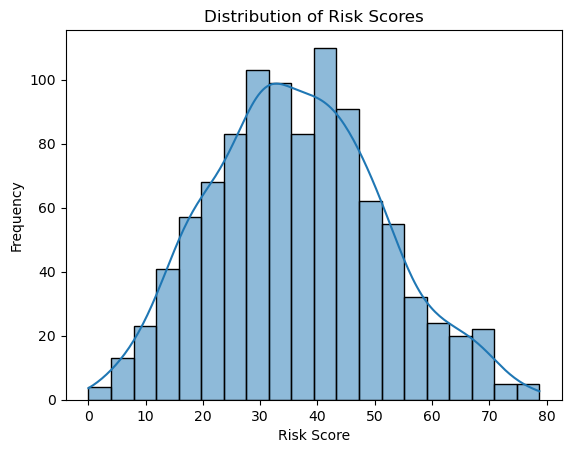

In [5]:
sns.histplot(df['risk_score'], kde=True)
plt.title('Distribution of Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.show()


In [6]:
def label (risk_score): # Dados obtidos na descrição do dataset
    if risk_score < 30:
        return 'low'
    elif risk_score <= 60:
        return 'medium'
    elif risk_score > 60:
        return 'high'
    else:
        raise ValueError('Invalid risk score')
    

In [7]:
df['risk_score'].apply(label).value_counts()

risk_score
medium    587
low       341
high       72
Name: count, dtype: int64

# Treinamento do Modelo

In [8]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [9]:
X = df.drop(columns=['user_id', 'date', 'risk_score'])
y = df['risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
from sklearn.tree import DecisionTreeRegressor

In [11]:
dtr_model = DecisionTreeRegressor()

In [12]:
dtr_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [13]:
y_pred = dtr_model.predict(X_test)

In [14]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 38.45375120897055
R2 Score: 0.8177260260577602
Root Mean Squared Error: 6.201108869304791


# Otimização de Hiperparâmetros

In [15]:
def get_grid_search_metrics_and_model_regressor(estimator, param_grid, X_train, y_train, X_test, y_test, estimator_name='estimator'):

  kfold = KFold(n_splits=5, shuffle=True)
  steps = [('scaler', StandardScaler()), (estimator_name, estimator)]
  
  pipeline = Pipeline(steps=steps)
  grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], cv=kfold, n_jobs=-1, refit='r2')

  grid_search.fit(X_train, y_train)
  y_pred = grid_search.predict(X_test)

  best_scores = {
      'r2_score': r2_score(y_test, y_pred),
      'mean_absolute_error': mean_absolute_error(y_test, y_pred),
      'mean_squared_error': mean_squared_error(y_test, y_pred),
      'root_mean_squared_error': root_mean_squared_error(y_test, y_pred)
  }

  print("Best parameters: {}".format(grid_search.best_params_))
  print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
  print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
  print("R2 score: {:.2f}".format(r2_score(y_test, y_pred)))
  print("Mean absolute error: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
  print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
  print("Root mean squared error: {:.2f}".format(root_mean_squared_error(y_test, y_pred)))
  return grid_search.best_estimator_, grid_search.best_params_, best_scores

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf_reg_param_grid = {
    "rf_reg__n_estimators": [25, 50, 100, 150],
    "rf_reg__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "rf_reg__max_depth": np.arange(3, 10),
    "rf_reg__min_samples_split": np.arange(2, 10),
}

model_name = "Random Forest Regressor"


model, params, score = get_grid_search_metrics_and_model_regressor(RandomForestRegressor(), rf_reg_param_grid, X_train, y_train, X_test, y_test, "rf_reg")

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'rf_reg__criterion': 'friedman_mse', 'rf_reg__max_depth': 9, 'rf_reg__min_samples_split': 2, 'rf_reg__n_estimators': 150}
Best cross-validation score: 0.89
Test set score: 0.91
R2 score: 0.91
Mean absolute error: 3.38
Mean squared error: 19.46
Root mean squared error: 4.41


[Documentação do MLFlow](https://mlflow.org/docs/latest/index.html)

In [20]:
score

{'r2_score': 0.9077571383500858,
 'mean_absolute_error': 3.3822786832886838,
 'mean_squared_error': 19.46017841150113,
 'root_mean_squared_error': 4.411369221851774}

In [21]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Risk of Diabetes Prediction")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    for key, value in score.items():
        mlflow.log_metric(key, value)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", f"{model_name} model for Risk of Diabetes Prediction")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'tracking-quickstart'.
2024/12/07 23:04:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, versi

🏃 View run honorable-shad-673 at: http://127.0.0.1:8080/#/experiments/931863216246664996/runs/5602164ba90440b2846d7d6e952ce931
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/931863216246664996


# Mão na massa

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor